In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 0.set up environment

In [ ]:
!pip install py7zr
#!pip install xformers
!pip install accelerate
!pip install -i https://pypi.org/simple/ bitsandbytes

In [ ]:
pip install tiktoken

In [ ]:
pip install einops transformers_stream_generator

In [ ]:
pip install modelscope

In [ ]:
pip install auto-gptq

In [ ]:
pip install optimum

In [ ]:
pip install "peft<0.8.0" deepspeed

In [ ]:
pip install mpi4py -i http://pypi.doubanio.com/simple/ --trusted-host pypi.doubanio.com

##1. load dataset which is processed by scripts

Qwen SFT traing foramt:


[
    {
      "id": "identity_0",
      "conversations": [
        {
          "from": "user",
          "value": ""
       },
       {
         "from": "assistant",
         "value": ""
       }
     ]
   }
 ]

In [ ]:
import pandas as pd
df = pd.read_json('/content/drive/MyDrive/ISS/5005/finetuning/train.json')

## 2. Load and fine-tune the model with QLoRA

### load qwen-7b-chat model

In [ ]:
import os
os.environ["MODELSCOPE_CACHE"] = "/content/drive/MyDrive/ISS/5005/finetuning/model"

In [ ]:
#下载模型
from modelscope import snapshot_download
from transformers import AutoModelForCausalLM, AutoTokenizer

model_dir = snapshot_download('qwen/Qwen-7B-Chat-Int4')


# Loading local checkpoints
# trust_remote_code is still set as True since we still load codes from local dir instead of transformers
tokenizer = AutoTokenizer.from_pretrained(model_dir, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_dir,
    device_map="auto",
    trust_remote_code=True
).eval()

2024-05-01 10:06:06,108 - modelscope - WARNING - Model revision not specified, use revision: v1.1.8
/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4371: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(
Downloading:  66%|██████▌   | 1.25G/1.90G [00:24<00:04, 151MB/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

### define a utility function to format prompts.

In [13]:
def generate_prompt(input):
  prompt_template = f"""
    分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.
    请根据不同的用户类型回答下面的问题

    交互格式如下：
    问题:用户提出的问题，如何治疗某种疾病或者其他类型问题
    回答:判断用户是不是病人,如果是病人,根据用户提出的问题，进行回答.如果不是,直接输出'<查询数据库>'

    现在开始：
    问题:{input}
    回答:
  """
  return prompt_template

In [ ]:
for index,row in df.iterrows():
  row['conversations'][0]['value'] = generate_prompt(row['conversations'][0]['value'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


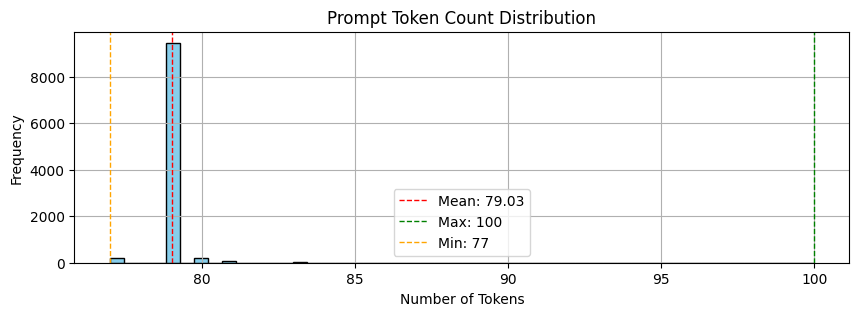

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import nltk

# Download NLTK's punkt tokenizer model
nltk.download('punkt')

# Prepare the data
token_counts = []
for index,row in df.iterrows():
    prompt = generate_prompt(row['conversations'][0]['value'])
    tokens = nltk.word_tokenize(prompt)  # Tokenize the prompt string using NLTK
    token_counts.append(len(tokens))

# Calculate statistics
mean_tokens = np.mean(token_counts)
max_tokens = np.max(token_counts)
min_tokens = np.min(token_counts)

# Plot the histogram
plt.figure(figsize=(10, 3))
plt.hist(token_counts, bins=50, color='skyblue', edgecolor='black')
plt.axvline(mean_tokens, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_tokens:.2f}')
plt.axvline(max_tokens, color='green', linestyle='dashed', linewidth=1, label=f'Max: {max_tokens}')
plt.axvline(min_tokens, color='orange', linestyle='dashed', linewidth=1, label=f'Min: {min_tokens}')
plt.title('Prompt Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df.to_json('/content/drive/MyDrive/ISS/5005/finetuning/train.json', orient='records')

### finetuning qwen-7b-chat

**use deepspeed to accelrate the traing speed(All arguments are in the finetune_qlora.sh)**

  --fp16 True \
  --num_train_epochs 2 \
  --per_device_train_batch_size 16 \
  --per_device_eval_batch_size 8 \
  --gradient_accumulation_steps 4 \
  --evaluation_strategy "no" \
  --save_strategy "steps" \
  --save_steps 1000 \
  --save_total_limit 10 \
  --learning_rate 3e-4 \
  --weight_decay 0.1 \
  --adam_beta2 0.95 \
  --warmup_ratio 0.01 \
  --lr_scheduler_type "cosine" \
  --logging_steps 1 \
  --report_to "none" \
  --model_max_length 512 \

In [ ]:
!bash /content/drive/MyDrive/ISS/5005/finetuning/ft.sh

[2024-05-01 08:21:56,116] [INFO] [real_accelerator.py:203:get_accelerator] Setting ds_accelerator to cuda (auto detect)
 [WARNING]  async_io requires the dev libaio .so object and headers but these were not found.
 [WARNING]  async_io: please install the libaio-dev package with apt
 [WARNING]  If libaio is already installed (perhaps from source), try setting the CFLAGS and LDFLAGS environment variables to where it can be found.
 [WARNING]  Please specify the CUTLASS repo directory as environment variable $CUTLASS_PATH
 [WARNING]  sparse_attn requires a torch version >= 1.5 and < 2.0 but detected 2.3
 [WARNING]  using untested triton version (2.3.0), only 1.0.0 is known to be compatible
2024-05-01 08:21:58.271129: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 08:21:58.271181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Una

## 3. Run inference using the fine-tuned model

load the finetuned model

In [10]:
import sys
sys.path.append('/content/drive/MyDrive/ISS/5005/finetuning/model/qwen/Qwen-7B-Chat-Int4')

In [11]:
from peft import AutoPeftModelForCausalLM

import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import GenerationConfig
from qwen_generation_utils import make_context, decode_tokens, get_stop_words_ids #important
from peft import AutoPeftModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(
    '/content/drive/MyDrive/ISS/5005/finetuning/model_finetuning',
    pad_token='<|extra_0|>',
    eos_token='<|endoftext|>',
    padding_side='left',
    trust_remote_code=True
)

model = AutoPeftModelForCausalLM.from_pretrained(
    '/content/drive/MyDrive/ISS/5005/finetuning/model_finetuning',
    pad_token_id=tokenizer.pad_token_id,
    device_map="auto",
    trust_remote_code=True
).eval()

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:4371: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

pick two samples to inference

In [14]:
prompt = generate_prompt('精神分裂症导致什么后果？')
response,_ = model.chat(tokenizer,prompt,history = None)
response

'请查询数据库'

In [15]:
prompt = generate_prompt('十分的不舒服，总是难受，想知道牙龈出血一个月不痛有口臭怎么回事？')
response,_ = model.chat(tokenizer,prompt,history = None)
response

'如果出现了口腔溃疡的情况和这种原因都是不一定的，在平时的时候要注意自己的口腔卫生，每天早晨都要洁面和晚上都要吃完东西后要漱口，对于这样的情况可以采用针灸的方法来进行调养，这样也可以有效的缓解，而且也要坚持去医院进行检查和治疗。最后，患者日常要养成良好的生活习惯，规律作息，禁烟酒，多增加日常锻炼以此来提高患者免疫力，避免病情复发。'

### Batch Inference

In [16]:
model.generation_config = GenerationConfig.from_pretrained('qwen/Qwen-7B-Chat-Int4', pad_token_id=tokenizer.pad_token_id)
model.generation_config.top_p = 0 #refuse model to generate randomly

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


generation_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

In [17]:
import pandas as pd
test = pd.read_json('/content/drive/MyDrive/ISS/5005/finetuning/test.json',lines = True)
test

,ask,answer
0,爷爷他是因为脑出血后，才有的癫痫病，后台父亲就隔代遗传到了爷爷的癫痫病，癫痫病复发下来，真的...,你好，根据你描述的情况看来癫痫症状需要有及时的尽早查明原因，早发觉，早治疗，建议患者首先实施...
1,什么是肾功能异常的症状？,请查询数据库
2,我母亲今年60岁，今天去医院做了彩超，患胆囊炎。请问：慢性胆囊炎的治疗方法都有什么？,目前皆以切除胆囊疗效最。手术疗法包括1.急性胆囊炎：一般主张经12~24小时积极的内科治疗，...
3,女宝宝，目前4岁，刚开始，嗓子眼有点痛，察觉到，吞咽好像有点困难，并且，有点发烧也没精神，请...,扁桃体炎治疗期间饮食也是非常关键的一点，建议宝妈是可以给孩子多吃一些蔬菜和水果的，因为很多水...
4,精神分裂症诊断的主要特征是什么？,请查询数据库
...,...,...
995,孤独症谱系障碍的治疗方法有哪些？,请查询数据库
996,蜘蛛咬伤会造成什么后果？,请查询数据库
997,我奶奶的高血压有点严重，我想知道这种高血压食盐摄入量要控制在什么范围内呢？,根据您目前叙述的情况，您说你奶奶高血压有点严重，这种情况确实需要有控制盐的摄取，让你奶奶一天...
998,什么是童年焦虑障碍？,请查询数据库


In [18]:
for index,row in test.iterrows():
  row['ask'] = generate_prompt(row['ask'])
all_row_text = test['ask'].tolist()

In [19]:
small_lists = [all_row_text[i:i+10] for i in range(0, len(all_row_text), 10)]

big_list = []
for small_list in small_lists:
    big_list.append(small_list)

In [20]:
def batch_generate(small_list):
  batch_raw_text = []
  for q in small_list:
      raw_text, _ = make_context(
          tokenizer,
          q,
          system="You are a helpful assistant for medical area.",
          max_window_size=model.generation_config.max_window_size,
          chat_format=model.generation_config.chat_format,
      )
      batch_raw_text.append(raw_text)
  return batch_raw_text

Inference on the whole testset and save the results (1000 samples, L4 GPU usage 15.9 G, duration 2h 22min 59s , speed 3s/sample)

In [22]:
from tqdm import tqdm

#each batch contains 10 samples
batch_response_list = []

for j in tqdm(range(len(big_list)), desc="Processing batches"):

    batch_raw_text = batch_generate(big_list[j])
    batch_input_ids = tokenizer(batch_raw_text, padding='longest')
    batch_input_ids = torch.LongTensor(batch_input_ids['input_ids']).to(model.device)
    batch_out_ids = model.generate(
        input_ids=batch_input_ids,
        return_dict_in_generate=False,
        generation_config=model.generation_config
    )
    padding_lens = [batch_input_ids[i].eq(tokenizer.pad_token_id).sum().item() for i in range(batch_input_ids.size(0))]
    # print(padding_lens)
    # print(batch_out_ids.shape)
    batch_response = [
        decode_tokens(
            batch_out_ids[i][padding_lens[i]:],
            tokenizer,
            raw_text_len=len(batch_raw_text[i]),
            context_length=(batch_input_ids[i].size(0) - padding_lens[i]),
            chat_format="chatml",
            verbose=False,
            errors='replace'
        ) for i in range(len(batch_raw_text))
    ]
    batch_response_list.append(batch_response)


Processing batches: 100%|██████████| 100/100 [2:21:08<00:00, 84.68s/it]


In [23]:
prediction = []
for i in range(len(batch_response_list)):
  for j in range(len(batch_response_list[i])):
    prediction.append(batch_response_list[i][j])

In [24]:
prediction = pd.DataFrame(prediction,columns = ['prediction_finetune'])

In [25]:
prediction_finetune = pd.merge(
    test,
    prediction,
    left_index = True,
    right_index = True
)

In [26]:
prediction_finetune.to_json('./prediction_finetune.json', force_ascii=False, orient='records', lines=True)

In [27]:
df_loaded = pd.read_json('./prediction_finetune.json', lines=True)
df_loaded

,ask,answer,prediction_finetune
0,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,你好，根据你描述的情况看来癫痫症状需要有及时的尽早查明原因，早发觉，早治疗，建议患者首先实施...,癫痫是一种慢性疾患，需要有长期服食药物来控制病情，一般情况下是不能够完全治好的，但是通过积极...
1,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,请查询数据库,请查询数据库
2,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,目前皆以切除胆囊疗效最。手术疗法包括1.急性胆囊炎：一般主张经12~24小时积极的内科治疗，...,慢性胆囊炎是临床诊断常见病、多发病，任何年龄均可再次出现，但以成年女性为多见。慢性胆囊炎急性...
3,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,扁桃体炎治疗期间饮食也是非常关键的一点，建议宝妈是可以给孩子多吃一些蔬菜和水果的，因为很多水...,在治疗儿童扁桃体炎的同时，饮食上也是需要引起足够重视的，一般是建议给孩子多吃一些水果和蔬菜的...
4,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,请查询数据库,请查询数据库
...,...,...,...
995,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,请查询数据库,请查询数据库
996,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,请查询数据库,请查询数据库
997,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,根据您目前叙述的情况，您说你奶奶高血压有点严重，这种情况确实需要有控制盐的摄取，让你奶奶一天...,您好，高血压患者一定要注意饮食方面的调养，平时尽量低盐低脂饮食，每天的食盐摄入量不要低于六克...
998,\n 分析用户是不是病人。如果是病人，他会询问如何治疗某种疾病.\n 请根据不同...,请查询数据库,请查询数据库
